[View in Colaboratory](https://colab.research.google.com/github/abhigoogol/Autoencoders-using-Pytorch/blob/master/Autoencoder.ipynb)

In [3]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print("GPU: ", torch.cuda.is_available())

0.4.0
GPU:  True


In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Courtesy : https://github.com/GunhoChoi
!wget --header="Host: raw.githubusercontent.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" "https://raw.githubusercontent.com/GunhoChoi/Kind-PyTorch-Tutorial/master/06_Autoencoder_Model_Save/model/autoencoder.pkl" -O "autoencoder.pkl" -c

--2018-10-11 19:39:12--  https://raw.githubusercontent.com/GunhoChoi/Kind-PyTorch-Tutorial/master/06_Autoencoder_Model_Save/model/autoencoder.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



# MNIST Dataset

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8
learning_rate = 0.01

In [0]:
traindataset = datasets.MNIST("./", train=True, download=True, transform=transform)
testdataset = datasets.MNIST("./", train=False, download=True, transform=transform)

In [0]:
traindataloader = DataLoader(traindataset, shuffle=True, batch_size=batch_size, num_workers=8)
testdataloader = DataLoader(testdataset, shuffle=False, batch_size=batch_size, num_workers=8)

## Encoder-Decoder (Big Network)

In [0]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1),
                               nn.ReLU(),
                               nn.BatchNorm2d(16),
                               nn.Conv2d(16, 32, 3, padding=1),
                               nn.ReLU(),
                               nn.BatchNorm2d(32),
                               nn.Conv2d(32, 64, 3, padding=1),
                               nn.ReLU(),
                               nn.BatchNorm2d(64),
                               nn.MaxPool2d(2, 2))
    self.layer2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1),
                               nn.ReLU(),
                               nn.BatchNorm2d(128),
                               nn.MaxPool2d(2, 2),
                               nn.Conv2d(128, 256, 3, padding=1),
                               nn.ReLU())
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(batch_size, -1)
    return out

encoder = Encoder().cuda()

In [0]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.layer1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
                                nn.ReLU(),
                                nn.BatchNorm2d(128),
                                nn.ConvTranspose2d(128, 64, 3, 1, 1),
                                nn.ReLU(),
                                nn.BatchNorm2d(64))
    self.layer2 = nn.Sequential(nn.ConvTranspose2d(64, 16, 3, 1, 1),
                                nn.ReLU(),
                                nn.BatchNorm2d(16),
                                nn.ConvTranspose2d(16, 1, 3, 2, 1, 1),
                                nn.ReLU())
  def forward(self, x):
    out = x.view(batch_size, 256, 7, 7)
    out = self.layer1(out)
    out = self.layer2(out)
    return out

decoder = Decoder().cuda()

In [0]:
parameters = list(encoder.parameters()) + list(decoder.parameters())
len(parameters)

32

In [0]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [0]:
traindataloader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [0]:
try:
	encoder, decoder = torch.load('autoencoder.pkl')
	print("\n--------Model Loaded--------\n")
except:
  print("No file")
  pass

In [0]:
for i in range(6):
  for image, label in traindataloader:
    image = Variable(image).cuda()
    optimizer.zero_grad()
    output = encoder(image)
    output = decoder(output)
    loss = loss_fn(output, image)
    loss.backward()
    optimizer.step()
  if i % 2 == 0:
    torch.save([encoder,decoder],'autoencoder.pkl')
    print(loss)

tensor(0.8272, device='cuda:0')
tensor(0.8368, device='cuda:0')
tensor(0.8515, device='cuda:0')


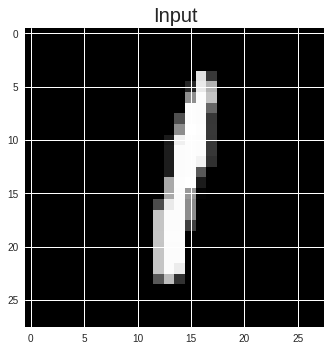

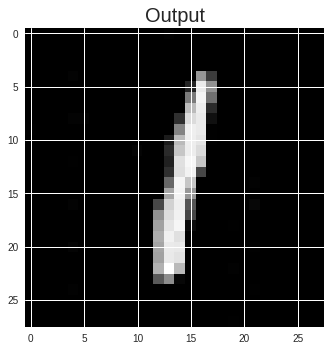

In [0]:
input_img = image[0].cpu()
output_img = output[0].cpu()

inp = input_img.data.numpy()
out = output_img.data.numpy()

plt.title("Input", fontsize=20)
plt.imshow(inp[0],cmap='gray')
plt.show()

plt.title("Output", fontsize=20)
plt.imshow(out[0],cmap="gray")
plt.show()


## Encoder-Decoder (Small Network)

In [0]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1),
                               nn.ReLU(),
                               nn.BatchNorm2d(64),
                               nn.MaxPool2d(2, 2))
    self.layer2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1),
                               nn.ReLU(),
                               nn.BatchNorm2d(128),
                               nn.MaxPool2d(2, 2),
                               nn.Conv2d(128, 256, 3, padding=1),
                               nn.ReLU())
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(batch_size, -1)
    return out

encoder = Encoder().cuda()

In [0]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    
#     class torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1)
        
    self.layer1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
                                nn.ReLU(),
                                nn.BatchNorm2d(128),
                                nn.ConvTranspose2d(128, 64, 3, 1, 1),
                                nn.ReLU(),
                                nn.BatchNorm2d(64))
    self.layer2 = nn.Sequential(nn.ConvTranspose2d(64, 1, 3, 2, 1, 1),
                                nn.ReLU())
  def forward(self, x):
    out = x.view(batch_size, 256, 7, 7)
    out = self.layer1(out)
    out = self.layer2(out)
    return out

decoder = Decoder().cuda()

In [75]:
parameters = list(encoder.parameters()) + list(decoder.parameters())
len(parameters)

20

In [0]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [31]:
traindataloader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [78]:
for i in range(6):
  for image, label in traindataloader:
    image = Variable(image).cuda()
    optimizer.zero_grad()
    output = encoder(image)
#     print(output.shape)
    output = decoder(output)
    loss = loss_fn(output, image)
    loss.backward()
    optimizer.step()
  print(loss)

tensor(0.8413, device='cuda:0')
tensor(0.8578, device='cuda:0')
tensor(0.8281, device='cuda:0')
tensor(0.8363, device='cuda:0')
tensor(0.8387, device='cuda:0')
tensor(0.8362, device='cuda:0')


### Test Model

In [0]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/2)
    plt.show()

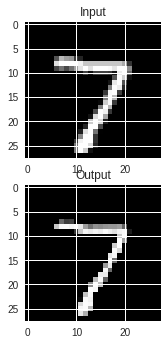

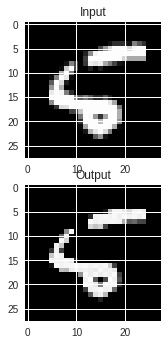

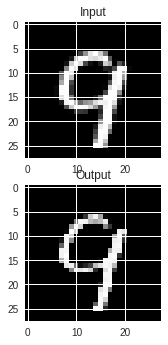

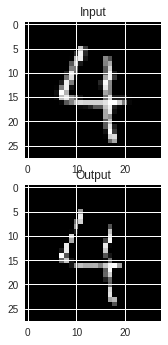

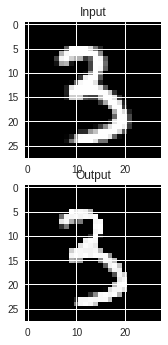

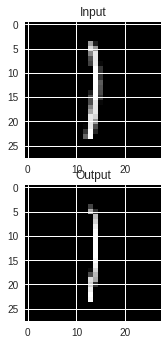

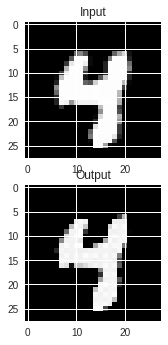

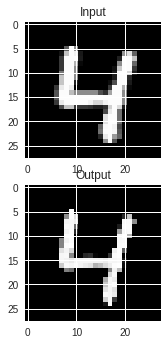

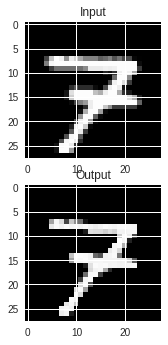

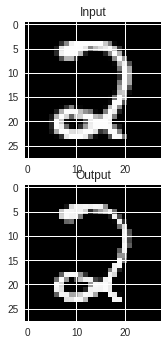

In [120]:
i = 1
number_images_show = 10
for image, label in testdataloader:
  image = Variable(image).cuda()
  output = encoder(image)
  output = decoder(output)
  
  input_img = image[0].cpu().detach().numpy()
  output_img = output[0].cpu().detach().numpy()
  img = np.concatenate((input_img, output_img), axis=0)
  show_images(img, cols = 2, titles = ["Input", "Output"])
  
  i+=1
  if i > number_images_show:
    break

# CIFAR10 Dataset (Ongoing)

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

batch_size = 8
learning_rate = 0.01

In [6]:
traindataset = datasets.CIFAR10("./", train=True, download=True, transform=transform)
testdataset = datasets.CIFAR10("./", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
traindataloader = DataLoader(traindataset, shuffle=True, batch_size=batch_size, num_workers=8)
testdataloader = DataLoader(testdataset, shuffle=False, batch_size=batch_size, num_workers=8)

In [8]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
dir(traindataloader)

['_DataLoader__initialized',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'batch_sampler',
 'batch_size',
 'collate_fn',
 'dataset',
 'drop_last',
 'num_workers',
 'pin_memory',
 'sampler',
 'timeout',
 'worker_init_fn']

In [9]:
len(traindataloader.dataset)

50000

In [0]:
trn = iter(traindataloader)
images, labels = next(trn)

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Encoder-Decoder (Big Network)

In [0]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1),
                               nn.ReLU(),
                               nn.BatchNorm2d(16),
                               nn.Conv2d(16, 32, 3, padding=1),
                               nn.ReLU(),
                               nn.BatchNorm2d(32),
                               nn.Conv2d(32, 64, 3, padding=1),
                               nn.ReLU(),
                               nn.BatchNorm2d(64),
                               nn.MaxPool2d(2, 2))
    self.layer2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1),
                               nn.ReLU(),
                               nn.BatchNorm2d(128),
                               nn.MaxPool2d(2, 2),
                               nn.Conv2d(128, 256, 3, padding=1),
                               nn.ReLU())
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(batch_size, -1)
    return out

encoder = Encoder().cuda()

In [0]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.layer1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
                                nn.ReLU(),
                                nn.BatchNorm2d(128),
                                nn.ConvTranspose2d(128, 64, 3, 1, 1),
                                nn.ReLU(),
                                nn.BatchNorm2d(64))
    self.layer2 = nn.Sequential(nn.ConvTranspose2d(64, 16, 3, 1, 1),
                                nn.ReLU(),
                                nn.BatchNorm2d(16),
                                nn.ConvTranspose2d(16, 1, 3, 2, 1, 1),
                                nn.ReLU())
  def forward(self, x):
    out = x.view(batch_size, 256, 7, 7)
    out = self.layer1(out)
    out = self.layer2(out)
    return out

decoder = Decoder().cuda()

In [0]:
parameters = list(encoder.parameters()) + list(decoder.parameters())
len(parameters)

32

In [0]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [0]:
traindataloader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [0]:
try:
	encoder, decoder = torch.load('autoencoder.pkl')
	print("\n--------Model Loaded--------\n")
except:
  print("No file")
  pass

In [0]:
for i in range(6):
  for image, label in traindataloader:
    image = Variable(image).cuda()
    optimizer.zero_grad()
    output = encoder(image)
    output = decoder(output)
    loss = loss_fn(output, image)
    loss.backward()
    optimizer.step()
  if i % 2 == 0:
    torch.save([encoder,decoder],'autoencoder.pkl')
    print(loss)

tensor(0.8272, device='cuda:0')
tensor(0.8368, device='cuda:0')
tensor(0.8515, device='cuda:0')


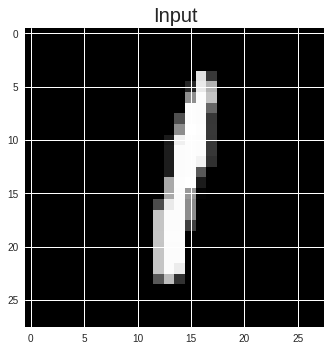

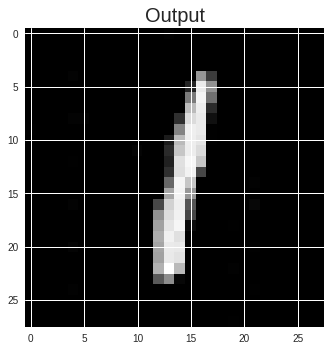

In [0]:
input_img = image[0].cpu()
output_img = output[0].cpu()

inp = input_img.data.numpy()
out = output_img.data.numpy()

plt.title("Input", fontsize=20)
plt.imshow(inp[0],cmap='gray')
plt.show()

plt.title("Output", fontsize=20)
plt.imshow(out[0],cmap="gray")
plt.show()


## Encoder-Decoder (Small Network)

In [0]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    
#     class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
    
    self.layer1 = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1),
                               nn.ReLU(),
                               nn.BatchNorm2d(64),
                               nn.MaxPool2d(2, 2))
    self.layer2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1),
                               nn.ReLU(),
                               nn.BatchNorm2d(128),
                               nn.MaxPool2d(2, 2),
                               nn.Conv2d(128, 256, 3, padding=1),
                               nn.ReLU())
  def forward(self, x):
#     print(x.shape)
    out = self.layer1(x)
#     print(out.shape)
    out = self.layer2(out)
#     print(out.shape)
    out = out.view(batch_size, -1)
#     print(out.shape)
    return out

encoder = Encoder().cuda()

In [0]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    
#     class torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1)
        
    self.layer1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
                                nn.ReLU(),
                                nn.BatchNorm2d(128),
                                nn.ConvTranspose2d(128, 64, 3, 1, 1),
                                nn.ReLU(),
                                nn.BatchNorm2d(64))
    self.layer2 = nn.Sequential(nn.ConvTranspose2d(64, 3, 3, 2, 1, 1),
                                nn.ReLU())
  def forward(self, x):
    out = x.view(batch_size, 256, 8, 8)
    out = self.layer1(out)
    out = self.layer2(out)
    return out

decoder = Decoder().cuda()

In [15]:
parameters = list(encoder.parameters()) + list(decoder.parameters())
len(parameters)

20

In [0]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [17]:
traindataloader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ./
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
                         )
    Target Transforms (if any): None

In [18]:
for i in range(6):
  for image, label in traindataloader:
    image = Variable(image).cuda()
    optimizer.zero_grad()
    output = encoder(image)
#     print(output.shape)
    output = decoder(output)
    loss = loss_fn(output, image)
    loss.backward()
    optimizer.step()
  print(loss)

tensor(0.4902, device='cuda:0')
tensor(0.3649, device='cuda:0')
tensor(0.3602, device='cuda:0')
tensor(0.4424, device='cuda:0')
tensor(0.3201, device='cuda:0')
tensor(0.5917, device='cuda:0')


### Test Model

In [0]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/2)
    plt.show()

In [41]:
tst = iter(testdataloader)
images, labels = next(tst)

image = Variable(image).cuda()
output = encoder(image)
output = decoder(output)

input_img = image[0].cpu()
output_img = output[0].cpu()

inp = input_img.data.numpy()
out = output_img.data.numpy()

img = input_img / 2 + 0.5
print(np.max(img))

# plt.title("Input", fontsize=20)
# plt.imshow(inp[0],cmap='jet')
# plt.show()

# plt.title("Output", fontsize=20)
# plt.imshow(out[0],cmap="jet")
# plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-8e24a954b2cd>", line 1, in <module>
    tst = iter(testdataloader)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 451, in __iter__
    return _DataLoaderIter(self)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 239, in __init__
    w.start()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.6/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/lib/python3.6/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 19, in __init__
    self._launch(pr

RuntimeError: ignored

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [30]:
i = 1
number_images_show = 1
for image, label in testdataloader:
  image = Variable(image).cuda()
  output = encoder(image)
  output = decoder(output)
  
  print(image.shape)
  
  input_img = image[0].cpu().detach()
  output_img = output[0].cpu().detach()
  imshow(input_img)
  imshow(output_img)
  
#   input_img = image[0].cpu().detach().numpy()
#   output_img = output[0].cpu().detach().numpy()
#   img = np.concatenate((input_img, output_img), axis=0)
#   show_images(img, cols = 8, titles = None)
  
  i+=1
  if i > number_images_show:
    break

torch.Size([8, 3, 32, 32])


ValueError: ignored